In [407]:
# from fastapi import FastAPI, File, UploadFile
# from fastapi.encoders import jsonable_encoder
# from fastapi.responses import JSONResponse
# from fastapi.middleware.cors import CORSMiddleware
# from starlette.middleware.cors import CORSMiddleware
import json
# from yahoofinancials imp\`ort YahooFinancials as YF
import time
import datetime
import pandas as pd
# from pandas_datareader import data
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
from utils import *
# from pydantic import BaseModelttt
from backtester import *
from backtest import *
import matplotlib.pyplot as plt
# import quandl
import math

%matplotlib inline

In [300]:
# gets stock ticket data for current day going back days_back
def getStocksData(tickers, days_back=10, save_new=False, path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"):
    def convert_time(epoch):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

    epoch_time = int(time.time())
    day_epoch = 60*60*24
    # tickers = df['Symbol'][:10]
    stocks = {}
    if (save_new):
        for tick in tqdm(tickers):
            try:

                # download dataframe
                # data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
                # data
                # stock_data =  pdr.get_data_yahoo(tick, start="2017-01-01", end="2022-02-20")
                stock_data =  pdr.get_data_yahoo(tick, period="3mo")
                stock_data = stock_data.reset_index()
                stocks[tick] = stock_data
                with open(path, 'wb') as handle:
                    pickle.dump(stocks, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
            except:
                print("Skipping stock for {}, bad data :<".format(tick))
    else:
        with open(path, 'rb') as handle:
            stocks = pickle.load(handle)
    return stocks

In [329]:
tickers = ['AAPL','T', 'MSFT']
stocks = getStocksData(tickers, 100, save_new=True)
stocks[tickers[0]].head()

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 1/3 [00:00<00:00,  3.88it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 2/3 [00:00<00:00,  4.26it/s]


[*********************100%***********************]  1 of 1 completed

100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-04-24,165.000000,165.600006,163.889999,165.330002,165.101639,41949600
1,2023-04-25,165.190002,166.309998,163.729996,163.770004,163.543793,48714100
2,2023-04-26,163.059998,165.279999,162.800003,163.759995,163.533798,45498800
3,2023-04-27,165.190002,168.559998,165.190002,168.410004,168.177383,64902300
4,2023-04-28,168.490005,169.850006,167.880005,169.679993,169.445618,55209200


In [166]:
# test offline stocks
days_back=10
save_new=False
path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"
with open(path, 'rb') as handle:
    stocks = pickle.load(handle)
# stocks[tickers[0]]

In [454]:
df = stocks['T']

In [452]:
df
initial_capital = 1000
ticker = 'T'
bars = df
positions = pd.DataFrame(bars.index)
isBankrupt = 0
positions


# def macd(self, long=21,short=13):
#     # df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
#     df = pd.DataFrame(index=self.bars.index)

#     # print(self.bars['Adj Close'])
#     df[self.ticker] = 0
#     df[self.ticker] = macd(

#         df=self.bars, short=short, long=long)
#     # print(df)
#     # TODO need to fix how df[self.ticker] is set since i did the reindexing
#     return df

# takes a df with colkumn "Adj Close" and returns a dataframe with
# index the same as df and 
def macd(df, short=12, long=26):
    exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
    exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
    df['macd'] = exp1-exp2
    # df['macd_signal'] = df['macd'].ewm(
    #     span=9, adjust=False).mean()
    df['macd_norm'] = (df['macd']-df['macd'].min()) / \
        (df['macd'].max()-df['macd'].min())
    return df['macd_norm']

macd1 = macd(df, 12,23)
macd2 = macd(df, 12,43)
macd3 = macd(df, 12,53)
strat1 = pd.DataFrame(bars.index)
strat1 = pd.DataFrame(5, index=bars.index, columns=['value'])

strat1 = pd.Series(500, index=bars.index)
strategies = [macd1,macd2,macd3,strat1]

# positions = pd.concat(strategies).groupby(level=0).sum()
# positions = pd.concat(strategies).groupby(level=0).mean()
# positions
positions['T_position'] = pd.DataFrame(5, index=bars.index, columns=['value'])

positions['T_position'] =  pd.concat(strategies).groupby(level=0).mean()

positions['T_position'].at[0] = 0
positions[ticker+'_open'] = bars.Open
positions[ticker+'_close'] = bars.Close



positions[ticker +'_pos_diff'] = positions[ticker+"_position"].diff()


# # backtest
positions[ticker+"_cash_needed"] = positions[ticker+"_pos_diff"] * bars.Open
positions[ticker+"_cash"] = initial_capital - positions[f'{ticker}_cash_needed'].cumsum()
positions[ticker+"_cash"] = initial_capital
positions[ticker+"_holdings"] = 0


cash_held = initial_capital
available_cash = initial_capital

for index, row in positions.iterrows():
    print(f"index: {index}")

    if (index == 0):
        continue

    # print(row[ticker+"_pos_diff"] )

    # print(positions.loc[index])

    # shares_to_buy = pos = row[ticker+"_pos_diff"]
    price = row[ticker+"_open"]
    cash = positions.loc[index-1][ticker+"_cash"]
    cash = positions.loc[index-1][ticker+"_holdings"]

    cash_needed = row[ticker+"_pos_diff"] * row[ticker+"_open"]

    if (cash > cash_needed):
        # make purchase
        cash = cash - cash_needed
        holdings = 

    # leftover = (pos*price % cash)
   
    if ((pos * price) > cash):
        print('here')
        leftover = (pos*price % cash)
        shares_to_buy = cash / price
        if not fractional:
            shares_to_buy = math.floor(shares_to_buy)
        print(f"buying {shares_to_buy}, {price * shares_to_buy}")
        print(f"cash left over {cash - (price * shares_to_buy)}")

    print(f"shares to buy {shares_to_buy}")
    print(f"leftover cash: {leftover}")
    # row[ticker+"_holdings"] = shares_to_buy
    # row[ticker+"_cash"] = leftover
    positions.at[index, f"{ticker}_holdings"] = shares_to_buy
    positions.at[index, f"{ticker}_cash"] = leftover



positions= positions.round(2)
    # if (row[ticker+"_cash_needed"] < 0):
    #     isBankrupt = index
    #     available_cash = initial_capital - positions[f'{ticker}_cash_needed'][:index-1].sum()
    #     print(f"{ticker} went bankrupt at {index} with {available_cash} of available cash and {initial_capital}")



# def setCash(pos, price, cash):
#     print(pos)
#     print(price)
#     if (pos*price > cash):
#         print('not enouch cash')
#         leftover = (pos*price % cash)
#         shares_to_buy = cash / price
#         if not fractional:
#             shares_to_buy = math.floor(shares_to_buy)
#         print(f"buying {shares_to_buy}, {price * shares_to_buy}")
#         print(f"cash left over {cash - (price * shares_to_buy)}")

# positions = positions.assign(
#     T_cash = lambda x: setCash(x['T_position'],x['T_open'], x['T_cash'])
# )




# df_filled = df.fillna(0)
positions
 

 
# macd1


index: 0
index: 1
here
buying 57, 998.0700130462646
cash left over 1.9299869537353516
shares to buy 57
leftover cash: 201.84039893892532
index: 2
shares to buy 57.504314841739415
leftover cash: 201.22189405130501
index: 3
shares to buy 11.613372191326532
leftover cash: 0.2914341070146736
index: 4
here
buying 0, 0.0
cash left over 0.2914341070146736
shares to buy 0
leftover cash: 0.05839780073829198
index: 5
shares to buy 0.016428078397675443
leftover cash: 0.012901322924223725
index: 6
shares to buy 0.0033639284956862307
leftover cash: 0.0014823700442663929
index: 7
shares to buy 0.0007522637440926863
leftover cash: 0.0005604742915802513
index: 8
shares to buy 8.709576994107599e-05
leftover cash: 6.317049866673419e-05
index: 9
shares to buy 3.300790969906203e-05
leftover cash: 5.42901315249561e-05
index: 10
shares to buy 3.7137270909306003e-06
leftover cash: 2.0357841311602343e-06
index: 11
shares to buy 3.174861421862139e-06
leftover cash: 4.745394124872071e-07
index: 12
shares to buy

,0,T_position,T_open,T_close,T_pos_diff,T_cash_needed,T_cash,T_holdings
0,0,0.00,18.09,17.53,NaN,NaN,1000.00,0.00
1,1,125.75,17.51,17.51,125.75,2201.84,201.84,57.00
2,2,125.71,17.39,17.20,-0.04,-0.62,201.22,57.50
3,3,125.73,17.38,17.61,0.02,0.29,0.29,11.61
4,4,125.75,17.42,17.67,0.02,0.35,0.06,0.00
...,...,...,...,...,...,...,...,...
57,57,125.19,14.12,13.53,-0.17,-2.43,NaN,NaN
58,58,125.05,13.53,13.45,-0.14,-1.91,NaN,NaN
59,59,125.07,14.32,14.59,0.02,0.29,NaN,NaN
60,60,125.10,14.59,14.66,0.03,0.43,NaN,NaN


In [451]:
positions.head(50)

,0,T_position,T_open,T_close,T_pos_diff,T_cash_needed,T_cash,T_holdings
0,0,0.00,18.09,17.53,NaN,NaN,1000.00,0.00
1,1,125.75,17.51,17.51,125.75,2201.84,201.84,57.00
2,2,125.71,17.39,17.20,-0.04,-0.62,201.22,57.50
3,3,125.73,17.38,17.61,0.02,0.29,0.29,11.61
4,4,125.75,17.42,17.67,0.02,0.35,0.06,0.00
5,5,125.75,17.74,17.50,-0.00,-0.05,0.01,0.02
6,6,125.70,17.36,17.07,-0.05,-0.85,0.00,0.00
7,7,125.66,17.15,17.09,-0.04,-0.62,0.00,0.00
8,8,125.61,17.02,16.91,-0.05,-0.81,0.00,0.00
9,9,125.60,16.98,17.13,-0.01,-0.22,0.00,0.00


In [411]:
pos = 8
price = 200
cash = 1250
fractional = False
if (pos*price > cash):
    print('not enouch cash')
    leftover = (pos*price % cash)
    shares_to_buy = cash / price
    if not fractional:
        shares_to_buy = math.floor(shares_to_buy)
    print(f"buying {shares_to_buy}, {price * shares_to_buy}")
    print(f"cash left over {cash - (price * shares_to_buy)}")

not enouch cash
buying 6, 1200
cash left over 50


In [357]:
print(macd1)
print(macd2)
print(macd3)


0     0.999110
1     0.995554
2     0.937722
3     0.966552
4     1.000000
        ...   
57    0.301579
58    0.080266
59    0.126699
60    0.186567
61    0.261518
Name: macd_norm, Length: 62, dtype: float64
0     1.000000
1     0.997321
2     0.953660
3     0.973628
4     0.997977
        ...   
57    0.253773
58    0.077212
59    0.096457
60    0.127861
61    0.172956
Name: macd_norm, Length: 62, dtype: float64
0     1.000000
1     0.997500
2     0.956727
3     0.975002
4     0.997534
        ...   
57    0.207113
58    0.040029
59    0.054396
60    0.080397
61    0.119546
Name: macd_norm, Length: 62, dtype: float64


In [372]:
# TODO 
# Add limit so capital can't go under 0



class Stock(object):
    def __init__(self, bars, ticker, initial_capital=1000):
        self.bars = bars # df of the Open, High, Low, Close, Adj Close, Volume, with Date as index
        self.ticker = ticker # str: ticket symbol
        self.positions = pd.DataFrame(
            index=self.bars.index) # empty df with same index as bars
        self.strategies = [] # list of df's with single column as the "buy signal" with the column name being the ticker
        self.initial_capital = float(initial_capital)
        self.isBankrupt = 0 # 0 if not bankrupt, date of bankruptcy

    def generate_positions(self):
#         print("generate positoins called", self.ticker)
#         print(self.strategies)
#         print(type(self.strategies))
        if not self.strategies:
            # create a series with same index and fixed value
            self.positions[self.ticker+"_position"] = pd.DataFrame(5, index=bars.index, columns=['value'])
            self.positions[self.ticker +'_pos_diff'] = self.positions[self.ticker+"_position"].diff()
            return self.positions

        print('strategies')
        print(self.strategies)
        print('positions')
        print(self.positions)
        self.positions = pd.concat(self.strategies).groupby(level=0).sum()

        self.positions[self.ticker+"_position"] = 1*self.positions[self.ticker]
        self.positions[self.ticker +
                       '_pos_diff'] = self.positions[self.ticker+"_position"].diff()
        
        self.positions.loc[self.positions.index[0],self.ticker +'_pos_diff'] = self.positions.loc[self.positions.index[0],self.ticker +'_position']
        return self.positions

    # takes your
    def backtest(self):
        if self.ticker+"_position" not in self.positions.columns:
            print(f"Generating positions first")
            self.generate_positions()
        holdings_col = []
        holdings_col.append(self.ticker+"_holdings")
        self.positions[self.ticker+'_cash_needed'] = (
            self.positions[self.ticker+'_pos_diff'] * self.bars.Open)
        # self.positions[self.ticker+"_holdings"] = self.bars.Open * \
        #     self.positions[self.ticker+'_position']

        self.positions[self.ticker+'_open'] = self.bars.Open
        self.positions[self.ticker+'_close'] = self.bars.Close



        # self.positions['holdings'] = self.positions[holdings_col].sum(axis=1)

        # self.positions['cash_diff'] = self.positions[[
        #     x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
        
        # print('test')
        # print([x.replace('_holdings', '_cash') for x in holdings_col])
        

        self.positions['cash'] = self.initial_capital - \
            self.positions[f'{self.ticker}_cash_needed'].cumsum()
        

        cash_held = self.initial_capital
        for index, row in self.positions.iterrows():
            if (row['cash'] < 0):
                self.isBankrupt = index
                available_cash = self.initial_capital - self.positions[f'{self.ticker}_cash_needed'][:index-1].sum()
                print(f"{self.ticker} went bankrupt at {index} with {available_cash} of available cash and {self.initial_capital}")



        

            # holdings = row[f'{self.ticker}_position'] * row[self.ticker+'_open']
            # cash_held = cash_held - holdings

            # if (cash_held < 0):
            #     print(f"{self.ticker} went bankrupt at {index}")
            #     self.isBankrupt = index
            #     break
            # else:
            #     self.positions.at[index, 'holdings'] = holdings

            #     self.positions.at[index, 'cash_diff'] = self.positions[[
            #         x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
            #     # self.positions.at[index,'cash'] = cash_held - \
            #     #     self.positions['cash_diff'].cumsum()
        


            

        # # self.positions['new_col'] = df.apply(lambda x: some_func(x['col1'], x['col2'])) 
        # self.positions = self.positions.assign(
        #     holdings = lambda x: self.setHoldings(x[f"{self.ticker}_position"],x[f"{self.ticker}_open"]),
        #     cash_diff = lambda x: self.setCash_Diff(x,holdings_col,x['holdings'], x[f'{self.ticker}_close']),
        #     cash = lambda x: x['holdings'] * x[f'{self.ticker}_close']
        # )
      
        
        # self.positions['total'] = self.positions['cash'] + \
        #     self.positions['holdings']
        

        # self.positions['returns'] = self.positions['total'].pct_change()
        # self.positions['date'] = self.positions.index.strftime("%m/%d/%Y")
        # self.positions = self.positions.fillna(0)
        return self.positions
    
    def setHoldings(self,position,open_price):
        print("set holdings")
        holdings = position * open_price
        if (self.initial_capital - holdings < 0):
            print(f"{self.ticker} stock position has gone broke")
        print(position)
        print(open_price)
        print(self.initial_capital)
        return position
    
    def setCash_Diff(self,df,holdings_col,holdings, close_price):
        cash_diff = df[[
            x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
        return cash_diff


    # takes a dict of weights and returns positions

    def buyWeights(self,weight):
        # assert(weights.keys() in self.bars.keys())
        # df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        df = pd.DataFrame(index=self.bars['Date'])
        df[self.ticker] = weight
        df[self.ticker][0:1] = 0.0
        return df

    def macd(self, long=21,short=13):
        # df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        df = pd.DataFrame(index=self.bars.index)
    
        # print(self.bars['Adj Close'])
        df[self.ticker] = 0
        df[self.ticker] = macd(
            df=self.bars, short=short, long=long)
        # print(df)
        # TODO need to fix how df[self.ticker] is set since i did the reindexing
        return df


In [373]:
stock = Stock(stocks['AAPL'], 'AAPL',100)
stock.ticker

strats = [
    stock.macd(long = 21, short = 1),
    stock.buyWeights(32)
]
stock.strategies = strats
stock.backtest()

stock.positions
# stock.positions['total'].plot()


# stock.positions
# stock.strategies[0].columns
# positions = pd.concat(stock.strategies).groupby(['Date']).sum()
# positions


# def merge_strategies(type="even", strats):
#     if (type=='even'):
        
    

Generating positions first
strategies
[        AAPL
0   0.129981
1   0.000000
2   0.010983
3   0.409245
4   0.489674
..       ...
57  0.643637
58  0.575247
59  0.649077
60  0.437516
61  0.310269

[62 rows x 1 columns],             AAPL
Date            
2023-04-24     0
2023-04-25    32
2023-04-26    32
2023-04-27    32
2023-04-28    32
...          ...
2023-07-17    32
2023-07-18    32
2023-07-19    32
2023-07-20    32
2023-07-21    32

[62 rows x 1 columns]]
positions
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

[62 rows x 0 columns]


/var/folders/9b/m93m8dss2n5dg56nzby_hzl40000gn/T/ipykernel_2300/3950719118.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.positions = pd.concat(self.strategies).groupby(level=0).sum()


TypeError: '<' not supported between instances of 'Timestamp' and 'int'

In [ ]:
stock.positions.loc[stock.isBankrupt]

AAPL               0.109028
AAPL_position      0.109028
AAPL_pos_diff           0.0
AAPL_cash               0.0
AAPL_holdings     17.995059
AAPL_open        165.050003
AAPL_close       165.020004
holdings          17.995059
cash_diff               0.0
cash                  100.0
total            117.995059
returns                 0.0
date             04/21/2023
Name: 2023-04-21 00:00:00, dtype: object

In [ ]:
class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    def __init__(self, tickers, bars, initial_capital=1000):
        self.tickers = tickers
        self.bars = bars # dict of the ticker:OHLC df
        self.stock_list = []
        self.stocks = {}  # dict of Class Stock[]
        # self.stocks = [Stock(self.stocks[x],x, self.initial_capital/len(self.tickers)) for x in self.tickers]
        self.backtest = {}
        self.positions = {} # might not be needed if the self.stocks will have the positions, we can store the aggregated positions here
        self.strategies = []
        self.initial_capital = initial_capital
        self.prepStockData()
        
    # takes a strat or list of stras and adds it to the stocks stratigies to execute
    # all takes a list of tickers to put the strategy in
    def addStrat(self, tickers, strat, **kwargs):
#         print('adding strat ', tickers, strat)
        for tick in tickers:
            print(f"adding ticker {tick}")
            if isinstance(strat, str):
                print("adding single strat")
                try:
                    func = getattr(self.stocks[tick], strat)(**kwargs)
#                     print(func)
                    self.stocks[tick].strategies.append(func)
                except AttributeError:
                    print("dostuff not found")
                
            else:
                print("adding multiple strats")
                print(self.stocks)
                print("strats")
                print(strat)
                
#                 self.stocks[tick].strategies.extend(strat)
                for signal in strat:
                    # print(signal)
                    self.stocks[tick].strategies.append(signal[tick])

#                     print('signal')
#                     print(signal)
#                     print('signal value:')

#                     print(signal['value'])
                    # self.stocks[signal['key']].strategies.append(signal['value']) 
               
                print(f"added strats {strats} to stocks {stocks}")

    # creates the Stock objects and adds them to the self.stocks dict
    def prepStockData(self):
        for ticker in self.tickers:
            self.stocks[ticker] = Stock(self.bars[ticker],ticker,1000) 


    def backtest_portfolio(self):
        for stock in self.tickers:
            self.stocks[stock].backtest()
        sample_df = self.stocks[self.tickers[0]].bars
#         print(sample_df)
        self.positions = pd.DataFrame(index=self.bars[next(iter(self.bars))].index) # empty df with same index as bars
        all_positions = [self.stocks[x].positions for x in self.tickers]
        self.positions = pd.DataFrame(index=sample_df[next(iter(sample_df))].index) # empty df with same index as bars

        sum_cols = ['holdings', 'cash', 'total']
        for col in sum_cols:
            self.positions[col] = pd.concat(all_positions).groupby('Date')[col].sum()

        return self.positions

    # returns a dict of the symbol:[a df of the strategy with a Date index]
    def markowitz(self, params, weight=1):
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        bars = addReturns(self.bars, 'Adj Close')
        port_returns = getPortReturns(bars)
        risk_free = 0
        markov_runs = 100
        tickers = self.bars.keys()
        df = pd.DataFrame(columns=["id", "return", "volatility", "weights"])
        for x in range(0, int(markov_runs)):
            weights = getRandomWeights(len(tickers))
            volatility = getPortWeightedVol(port_returns, weights)
            ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
            row = {
                "id": x,
                "return": ann_ret,
                "volatility": volatility,
                "weights": weights
            }
            # df = df.append(row, ignore_index=True)
            # df = df.concat([df,row])
            df = pd.concat([df, pd.DataFrame.from_records([row])])
        df["sharpe"] = (df["return"] - risk_free) / df["volatility"]

        MSR = df.sort_values(by=["sharpe"], ascending=False).head(1)
        GMV = df.sort_values(by=["volatility"], ascending=True).head(1)
        weights = {}
        for index, x in enumerate(list(MSR['weights'])[0]):
            weights[list(tickers)[index]] = x * weight

        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        for ticker in params['tickers']:
            df[ticker] = weights[ticker]
        print("Optimum", weights)
        # buy weights
        result = {}
        for stock in self.tickers:
#             print(stock)
#             print(self.stocks[stock].buyWeights(weights[stock]))
            # strategy = {
            #     'key': stock,
            #     'value':self.stocks[stock].buyWeights(weights[stock])
            # }
            result[stock] = self.stocks[stock].buyWeights(weights[stock])
#             result[stock] = self.stocks[stock].buyWeights(weights[stock])
#             self.stocks[stock].strategies.append(self.stocks[stock].buyWeights(weights[stock])) #= [self.stocks[stock].buyWeights(weights[stock])]
        return result
     
    # returns a dict of the symbol:[a df of the strategy with a Date index]
    def buyEven(self, weight=1):
        result = []
        for stock in self.stocks.keys():
#             result[stock] = self.stocks[stock].buyWeights(weight)
            strategy = {
                'key': stock,
                'value':self.stocks[stock].buyWeights(weight)
            }
            result.append(strategy)
#             self.stocks[stock].strategies.append(self.stocks[stock].buy 

Optimum {'AAPL': 0.520155714104913, 'T': 0.003489042485182706, 'MSFT': 0.47635524340990426}
adding ticker AAPL
adding multiple strats
{'AAPL': <__main__.Stock object at 0x158214a90>, 'T': <__main__.Stock object at 0x158314f50>, 'MSFT': <__main__.Stock object at 0x1582b9910>}
strats
({'AAPL':                 AAPL
Date                
2023-04-21  0.000000
2023-04-24  0.520156
2023-04-25  0.520156
2023-04-26  0.520156
2023-04-27  0.520156
...              ...
2023-07-14  0.520156
2023-07-17  0.520156
2023-07-18  0.520156
2023-07-19  0.520156
2023-07-20  0.520156

[62 rows x 1 columns], 'T':                    T
Date                
2023-04-21  0.000000
2023-04-24  0.003489
2023-04-25  0.003489
2023-04-26  0.003489
2023-04-27  0.003489
...              ...
2023-07-14  0.003489
2023-07-17  0.003489
2023-07-18  0.003489
2023-07-19  0.003489
2023-07-20  0.003489

[62 rows x 1 columns], 'MSFT':                 MSFT
Date                
2023-04-21  0.000000
2023-04-24  0.476355
2023-04-25  0.47

<Axes: xlabel='Date'>

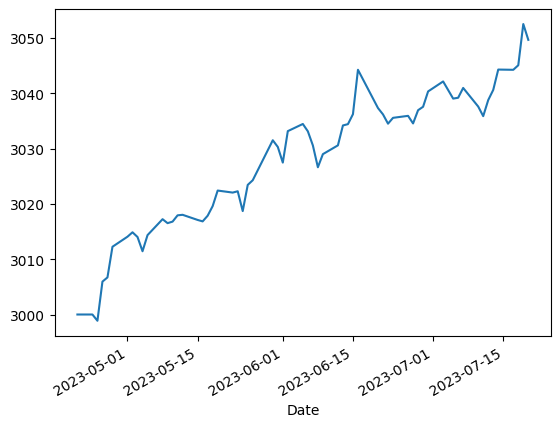

In [ ]:
tickets =  ['AAPL', 'T','MSFT']
port = Portfolio(tickets, stocks,10000);
markowtiz_params = {
    'tickers': ['AAPL', 'T','MSFT'],
    'weight':1
}
strats = port.markowitz(params = markowtiz_params,weight=1),
    # port.buyEven(3),

port.addStrat(tickets,strats)
port.backtest_portfolio()

port.positions['total'].plot()

# port.stocks['T'].positions

# port.stocks['AAPL'].positions.total.plot()

# port.markowitz(params = markowtiz_params,weight=1)['T'].positions
# stocks

# tickers

In [ ]:
port.markowitz(params = markowtiz_params,weight=1)

Optimum {'AAPL': 0.7421837881156286, 'T': 0.0269034697609557, 'MSFT': 0.23091274212341567}


{'AAPL':                 AAPL
 Date                
 2023-04-21  0.000000
 2023-04-24  0.742184
 2023-04-25  0.742184
 2023-04-26  0.742184
 2023-04-27  0.742184
 ...              ...
 2023-07-14  0.742184
 2023-07-17  0.742184
 2023-07-18  0.742184
 2023-07-19  0.742184
 2023-07-20  0.742184
 
 [62 rows x 1 columns],
 'T':                    T
 Date                
 2023-04-21  0.000000
 2023-04-24  0.026903
 2023-04-25  0.026903
 2023-04-26  0.026903
 2023-04-27  0.026903
 ...              ...
 2023-07-14  0.026903
 2023-07-17  0.026903
 2023-07-18  0.026903
 2023-07-19  0.026903
 2023-07-20  0.026903
 
 [62 rows x 1 columns],
 'MSFT':                 MSFT
 Date                
 2023-04-21  0.000000
 2023-04-24  0.230913
 2023-04-25  0.230913
 2023-04-26  0.230913
 2023-04-27  0.230913
 ...              ...
 2023-07-14  0.230913
 2023-07-17  0.230913
 2023-07-18  0.230913
 2023-07-19  0.230913
 2023-07-20  0.230913
 
 [62 rows x 1 columns]}

In [ ]:
tickers =[ 'T','MSFT']
port = Portfolio(tickers, stocks,10000);
params = {
    'tickers': tickers,
    'weight':1
}
strats = [
    port.markowitz(params = markowtiz_params,weight=1),
    port.buyEven(1),
    
  
]

port.addStrat(['T','MSFT'],strats)


# print(len(stock.macd(long = 21, short = 1)))
# print(isinstance(strats, pd.DataFrame))

port.addStrat(['T'],'macd',long=21,short=1)

# port.addStrat(['T'],stock.macd(long = 21, short = 1))
# port.addStrat(['T'],strat='macd',long = 21, short = 1)
# port.stocks['T'].strategies.append(stock.macd(long = 21, short = 1))
# port.stocks['T'].strategies[2]
# port.strategies = strats

port.backtest_portfolio()
port.positions.total.plot()

# port.stocks['T'].strategies[1]['T'].strategies[1]
# port.markowitz(params = markowtiz_params,weight=1)



# port.buyEven(1)
# port.stocks
# stock.macd(long = 21, short = 1)

Optimum {'AAPL': 0.5231566518805837, 'T': 0.0005687598882362746, 'MSFT': 0.47627458823118013}
adding multiple strats
{'T': <__main__.Stock object at 0x17ddb6790>, 'MSFT': <__main__.Stock object at 0x17ddad8d0>}


TypeError: list indices must be integers or slices, not str